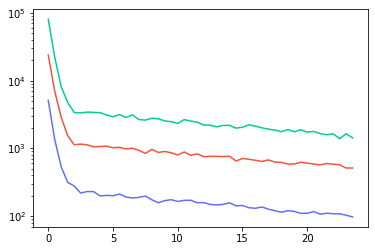

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import myokit
from scipy.integrate import odeint
import pints
import pints.plot
import pints.toy
import math
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.colors
from plotly.validators.scatter.marker import SymbolValidator


raw_symbols = SymbolValidator().values

class Model(pints.ForwardModel):
    
    def __init__(self):
        m = myokit.load_model('ThreeCompartment_IV_Model.mmt') #path for the model file 
        p = myokit.load_protocol('protocol_New.mmt')#path for the protocol file(e.g. dose regimen)
      
        self.simulation = myokit.Simulation(m, p) #define simulation (i.e. run the model via myokit)

    def n_parameters(self):
        return 6 # number of parameters to Fit
    
    def dimension(self):
        # Return the dimension of the parameter vector
        return 6

    def simulate(self, parameters, times):
        Drug_Central = []
        
       #setting up simulation parameters 
        self.simulation.set_state(save_state)
        self.simulation.reset()     
        self.simulation.set_time(0)
        self.simulation.set_constant('AllCompartment.CL', parameters[0]) # define parameter 
        self.simulation.set_constant('AllCompartment.Vc', parameters[1]) # define parameter 
        self.simulation.set_constant('AllCompartment.Qp1', parameters[2]) # define parameter 
        self.simulation.set_constant('AllCompartment.Vp1', parameters[3]) # define parameter 
        self.simulation.set_constant('AllCompartment.Qp2', parameters[4]) # define parameter 
        self.simulation.set_constant('AllCompartment.Vp2', parameters[5]) # define parameter
                                 
        # simulating multiple dose levels
        var_to_log = 'AllCompartment.Drug_Concentration_Central'
        
        DoseAmounts=drug_conc # Define dose level, can move this line to the initialization part 
        for i in range(len(DoseAmounts)):
            self.simulation.reset()  
            self.simulation.set_constant('dose.doseAmount', float(DoseAmounts[i]))
            Output = self.simulation.run(times[-1]+1, log=[var_to_log], log_times = times)
            Drug_Central.append(Output[var_to_log])
        
        return np.array(Drug_Central).T


m = myokit.load_model('ThreeCompartment_IV_Model.mmt') #path for the model file 
p = myokit.load_protocol('protocol_New.mmt') #path for the protocol file(e.g. dose regimen)

ref = myokit.Simulation(m, p) #set up myokit model: input model and protocol 
save_state = ref.state()  #save the original initial state 

# Then create an instance of our new model class
model = Model()

true_params  = [3,5,8,50,2,10] 

# Total  amount of drug dosed: 1mg/kg, 5mg/kg and 15mg/kg dose for mice (unit ng)
TotalDoseLevel= np.array([25000, 125000, 375000])

event_duration = p.events()[0].duration() # Extract duration of the dosing event from the protocol
drug_conc = TotalDoseLevel / event_duration

param_test=[3,5,8,50,2,10] 

#times= [0.1,1,1.5,2,2.5,3,4,5,6,7,8,8.5,9,10,11,12,13,14,15,16,16.5,17,18,19,20,22,24]
times= np.arange(0.01, 24, 0.5)

# run a test simulation
values=np.array(model.simulate(param_test ,times))

values = np.array([v + np.random.normal(0, 0.05, v.shape)*v for v in values])
values = np.transpose(values)

synthesized_data = {'time': times,
                 'observation': values}

        
colorlist=plotly.colors.qualitative.Plotly

plt.figure()
for i in range(len(drug_conc)):
    drug_conc_i = drug_conc[i]
    plt.semilogy(synthesized_data['time'],synthesized_data['observation'][i,:], color=colorlist[i])


In [37]:
#%% Define error function for fitting 
class ScoreFunction(pints.ErrorMeasure):
    
    def __init__(self, model, times, values, simulate_param):
        # Using sum of squares error for all values
        #
        # model: pints.ForwardModel
        # times: time series to simulate
        # values: multiple series that match model with simulate_param
        # simulate_param: parameters that correspond to each series in values
        super(ScoreFunction, self).__init__()
        
        self._model = model
        self._dimension = self._model.dimension()
        self._times = times
        if len(values) == len(simulate_param):
            self._values = np.asarray(values)
            self._param = np.asarray(simulate_param)
        else:
            raise ValueError('Length of values must be the same as simulate_param')

    def dimension(self):
        """ See :meth:`ErrorMeasure.dimension`. """
        return self._dimension
    
    def n_parameters(self):
        return self._dimension

    def __call__(self, x):
        total = 0
        # go through all simulation parameter (drug concentration)
        # simulate the model
        values = self._model.simulate(x, self._times)
        values = np.transpose(values)
        for i in range(len(self._param)):
            # drug_conc=self._param[i]
            #self._model.simulation.set_constant('dose.doseAmount', self._param[i])

            # sum of square error for corresponding values
     
            total += np.sum(((values[i] - self._values[i])/self._values[i])**2)
            
            #total += np.sum((np.log10(values) - np.log10(self._values[i]))**2)
            #total += np.sum(((np.log10(values) - np.log10(self._values[i]))/np.log10(self._values[i]))**2)
        return total
# In[21]: Optimization 

InitialEstimate = [2,6,9,45,3,12] 
boundaries =  pints.RectangularBoundaries([1,1,1,1,1,1] , [10,10,30,100,10,20])

# Add some noise
#values = [v + np.random.normal(0, 0.05*np.max(v), v.shape) for v in values]

# Create self defined score function
score = ScoreFunction(model, times, values, drug_conc)

found_parameters, found_value = pints.optimise(score, InitialEstimate, boundaries=boundaries, method=pints.CMAES)

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(true_params[k]))



Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      2.43431    0:00.1
1     18     1.028012   0:00.1
2     27     1.028012   0:00.2
3     36     1.028012   0:00.2
20    189    0.612      0:01.4
40    369    0.341      0:02.4
60    549    0.32       0:03.3
80    729    0.32       0:04.2
100   909    0.32       0:05.0
120   1089   0.32       0:05.9
140   1269   0.32       0:06.7
160   1449   0.32       0:07.6
180   1629   0.32       0:08.5
200   1809   0.32       0:09.3
220   1989   0.32       0:10.2
240   2169   0.32       0:11.0
260   2349   0.32       0:12.1
280   2529   0.32       0:13.0
300   2709   0.32       0:13.8
320   2889   0.32       0:14.7
340   3069   0.32       0:15.6
360   3249   0.32       0:16.5
380   3429   0.32       0:17.3
400   3609   0.32       0:18.3
420   3789   0.32       0:19.2
440   3969   0.32       0:20.1
460   4149   0.32       0:20

In [38]:

time_test = np.arange(0, 24, 0.1)    

# Plot the results
pop_vs_time_fig = go.Figure()
for i in range(len(drug_conc)):
    plotting_conc = drug_conc[i]
    pop_vs_time_fig.add_trace(go.Scatter(
        x = times,
        y = values[i],
        name = 'Obs. drug conc %s mg/kg' %(str(drug_conc[i])),
        showlegend = True,
        mode = 'markers',
        marker = dict(size = 12, color = colorlist[i])
    ))
    pop_vs_time_fig.add_trace(go.Scatter(
        x = time_test,
        y = np.transpose(model.simulate(found_parameters, time_test))[i],
        name = 'Pred. drug conc %s mg/kg' %(str(drug_conc[i])),
        showlegend = True,
        mode = 'lines',
        line=dict(width = 1.5, color=colorlist[i])
    ))
pop_vs_time_fig.update_layout(height=800, width=1200,xaxis_title = 'Time (h)', yaxis_title='CFU', yaxis_type = 'log',template="plotly_white", font = dict(size = 25, family = 'Times New Roman'))

Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 5 chains.
Running in sequential mode.
Writing chains to /Users/lavex/Documents/GitHub/Synth_data/notebooks_output/CompleteTK_LogCFUGaussianNoise_Chain_0.csv etc.
Writing evaluations to /Users/lavex/Documents/GitHub/Synth_data/notebooks_output/CompleteTK_LogCFUGaussianNoise_PLogPDF_0.csv etc.
Iter. Eval.  Accept.   Accept.   Accept.   Accept.   Accept.   Time m:s
0     5       0         0         0         0         0          0:00.0
1     10      0.5       0         0.5       0         0          0:00.1
2     15      0.667     0.333     0.333     0.333     0.333      0:00.1
3     20      0.5       0.5       0.25      0.5       0.25       0:00.1
20    105     0.571     0.238     0.571     0.0952    0.238      0:00.5
40    205     0.488     0.122     0.366     0.0732    0.122      0:00.9
60    305     0.41      0.082     0.344     0.0492    0.082      0:01.2
80    405     0.494     0.0864    0.42      0.037     0.0617  

/var/folders/yc/j4tvwj614cnfz3snw21mg8q40000gn/T/ipykernel_76588/419667480.py:55: RuntimeWarning:

invalid value encountered in log10



1500  7505    0.13      0.00666   0.249     0.00666   0.00933    0:22.0
1520  7605    0.128     0.00657   0.246     0.00657   0.0092     0:22.2
1540  7705    0.127     0.00649   0.243     0.00649   0.00909    0:22.6
1560  7805    0.125     0.00705   0.23959   0.00641   0.00897    0:22.9
1580  7905    0.124     0.00696   0.237     0.00633   0.00886    0:23.2
1600  8005    0.122     0.00687   0.234     0.00625   0.00874    0:23.4
1620  8105    0.120913  0.00679   0.231     0.00617   0.00864    0:23.7
1640  8205    0.119     0.0067    0.229     0.00609   0.00853    0:24.0
1660  8305    0.118     0.00662   0.226     0.00602   0.00843    0:24.3
1680  8405    0.117     0.00654   0.223     0.00595   0.00833    0:24.6
1700  8505    0.115     0.00647   0.22      0.00588   0.00823    0:24.9
1720  8605    0.114     0.00639   0.218     0.00581   0.00813    0:25.1
1740  8705    0.112579  0.00632   0.215     0.00574   0.00804    0:25.4
1760  8805    0.111     0.00625   0.213515  0.00568   0.00795   

(<Figure size 1728x1728 with 64 Axes>,
 array([[<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='Parameter2'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='Parameter3'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='Parameter4'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='Parameter5'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='Parameter6'>, <AxesSubplot:>,
         <AxesSubplot:>, <A

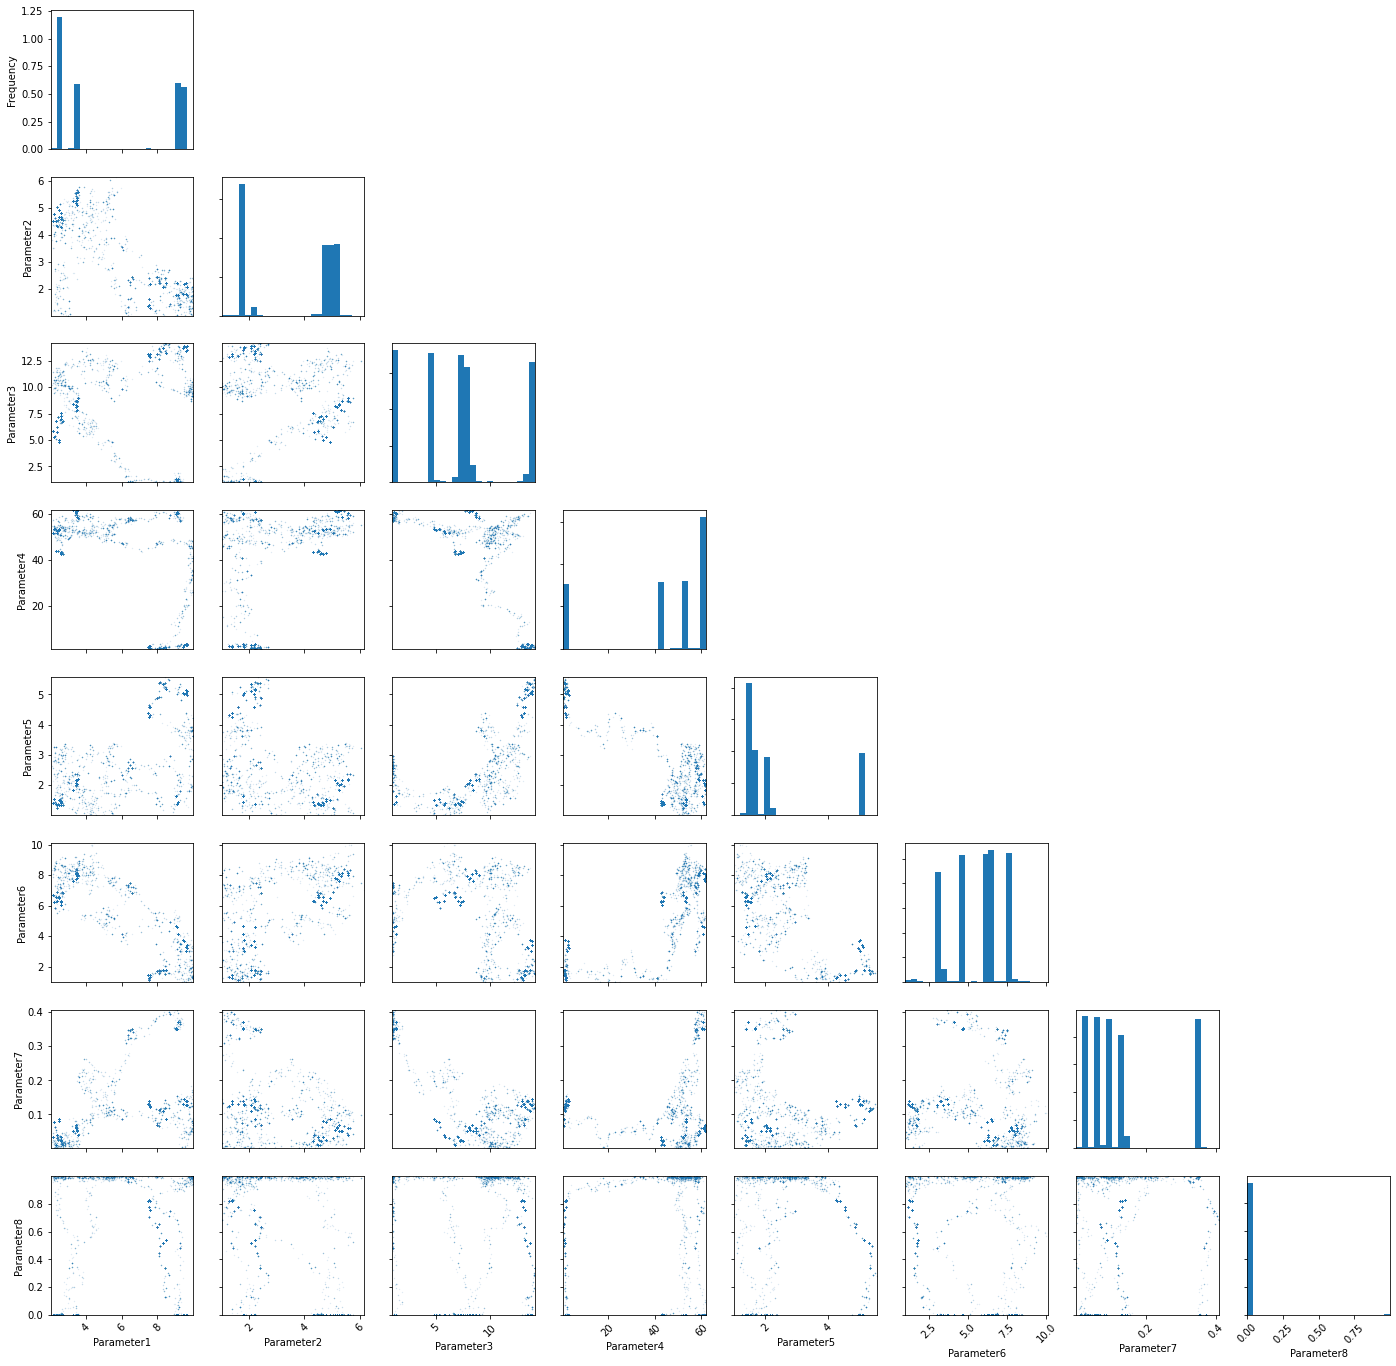

In [40]:
#%% Define loglikelihood 

class MultiGaussLogLikelihood(pints.ProblemLogLikelihood):
    '''
    Define a tailored log-Likelihood for our problem.
    '''
    def __init__(self, model, times, values, simulate_param):
        # Using sum of squares error for all values
        #
        # model: pints.ForwardModel
        # times: time series to simulate
        # values: multiple series that match model with simulate_param
        # simulate_param: parameters that correspond to each series in values
        # super(LogLikelihoodWithNoise, self).__init__()
        
        self._model = model
        self._dimension = self._model.dimension() + 1
        self._n_parameters = self._model.n_parameters() + 2
        self._times = times
        self._np = 2
        #print(str(len(values)))
        #print(str(len(simulate_param)))
        if len(values) == len(simulate_param):
            self._values = np.asarray(values)
            self._param = np.asarray(simulate_param)
        else:
            raise ValueError('Length of values must be the same as simulate_param')
        self._size = len(self._times)
        self._logn = 0.5 * self._size * np.log(2 * np.pi)

    def dimension(self):
        return self._dimension

    def __call__(self, x):

        total = 0
        noise_parameters = x[-self._np:]
        eta = np.asarray(noise_parameters[0::2])
        sigma = np.asarray(noise_parameters[1::2])
        valuesSim = np.transpose(self._model.simulate(x[:-self._np], self._times))
        # go through all simulation parameter (drug concentration)
        for i in range(len(self._param)):
            # simulate the model
            sim_param=self._param[i]
            drug_conc=self._param[i]
            
            valuesActual = self._values[i]

            # total += \
            #     -self._logn - np.sum(
            #         np.sum(np.log(valuesSim**eta * sigma), axis=0)
            #         + 0.5 / sigma**2 * np.sum(
            #             (valuesActual - valuesSim)**2
            #             / valuesSim ** (2 * eta), axis=0))
            error = np.log10(valuesSim[i]) - np.log10(self._values[i])
            # sum of square error for corresponding values
            total += self._logn + self._size * np.log(x[-1]) \
                     + np.sum(error**2) / (2 * x[-1]**2)
        return total

class GaussLogLikelihood(pints.ProblemLogLikelihood):
    '''
    Define a tailored log-Likelihood for our problem.
    '''
    def __init__(self, model, times, values, simulate_param):
        # Using sum of squares error for all values
        #
        # model: pints.ForwardModel
        # times: time series to simulate
        # values: multiple series that match model with simulate_param
        # simulate_param: parameters that correspond to each series in values
        # super(LogLikelihoodWithNoise, self).__init__()
        
        self._model = model
        self._dimension = self._model.dimension() + 1
        self._n_parameters = self._model.n_parameters() + 1
        self._times = times
        #print(str(len(values)))
        #print(str(len(simulate_param)))
        if len(values) == len(simulate_param):
            self._values = np.asarray(values)
            self._param = np.asarray(simulate_param)
        else:
            raise ValueError('Length of values must be the same as simulate_param')
        self._size = len(self._times)
        self._logn = 0.5 * self._size * np.log(2 * np.pi)

    def dimension(self):
        return self._dimension

    def __call__(self, x):
        # Note x[:-1] model parameters; x[-1] is noise.
        total = 0
        # go through all simulation parameter (drug concentration)
        for i in range(len(self._param)):
            # simulate the model
            drug_conc=self._param[i]
            sim_param=self._param[i]
            
            valuesSim = np.transpose(self._model.simulate(x, self._times))
            
            error = np.log10(valuesSim) - np.log10(self._values[i])
            #error = log10(valuesSim) - log10(self._values[i])
            # sum of square error for corresponding values
            total += self._logn + self._size * np.log(x[-1]) \
                    + np.sum(error**2) / (2 * x[-1]**2)
        return -1.0 * total
#%% MCMC  on synthesized data 
Noise_sigma = 0.05
Noise_eta = 0.01
initialPoint=10000 #Excessively small just so the Notebook runs faster, optimal value >10'000

# ConstantAndMultiplicativeGaussianLogLikelihood
log_likelihood = MultiGaussLogLikelihood(model, times, values, drug_conc)
#pints.MultiplicativeGaussianLogLikelihood()
# Starting point use optimised result

#true params are [2.3, 1e9, 3.2, 0.5, 3.8, 44, 0.002, 3.1, 0.3, 2.8]
log_prior = pints.UniformLogPrior([1,1,1,1,1,1,0,0] , [10,10,30,100,10,20,1,1])

log_posterior = pints.LogPosterior(log_likelihood, log_prior)

found_parameters_noise = np.array(list(found_parameters) + [Noise_eta] + [Noise_sigma])

# Choose starting points for 5 mcmc chains
xs = [
    found_parameters_noise * 1,
    found_parameters_noise * 0.9,
    found_parameters_noise * 1.05,
    found_parameters_noise * 0.95,
    found_parameters_noise * 1.1,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(50000) #Excessively small just so the Notebook runs faster, optimal value >50'000

# Start adapting after 10000 iterations
mcmc.set_initial_phase_iterations(initialPoint)

mcmc.set_chain_filename('/Users/lavex/Documents/GitHub/Synth_data/notebooks_output/CompleteTK_LogCFUGaussianNoise_Chain.csv')
mcmc.set_log_pdf_filename('/Users/lavex/Documents/GitHub/Synth_data/notebooks_output/CompleteTK_LogCFUGaussianNoise_PLogPDF.csv')

print('Running...')
chains = mcmc.run()
print('Done!')
pints.plot.pairwise(np.vstack(chains), kde=False)
